In [94]:
import torch
from xtfc_model import ValueFunctionModel
from utils import *
from hparams import hparams
import numpy as np

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = ValueFunctionModel(in_dim=2, out_dim=1, hparams={**hparams, 'hidden_units': [50, 20]}).to(device)
model.load_state_dict(torch.load("models/inverted-pendulum_xtfc_[50, 20]_SiLU.pt", map_location=device))
model.eval()


ValueFunctionModel(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=20, bias=True)
  )
  (y): Linear(in_features=20, out_features=1, bias=False)
  (activation): SiLU()
)

In [96]:
def wrap_angle(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ((angle + np.pi) % (2 * np.pi)) - np.pi
    return wrapped

In [ ]:
class PendulumState:
    def __init__(self, model, hparams):
        self.theta = 1.0
        self.theta_dot = 1.0
        self.control_input = 0.0
        self.time = 0.0
        self.model = model
        self.hparams = hparams

        self.g = hparams['gravity']
        self.l = hparams['length']
        self.m = hparams['mass']

        self.q = hparams['Q']
        self.r = hparams['R']

    def compute_control_input(self, grad_v):
        V_x2 = grad_v[1]
        u = -V_x2 / (2 * self.l**2 * self.m * self.r[0, 0])
        return u

    def step(self, dt, control_input):
        state_tensor = torch.tensor([self.theta, self.theta_dot], dtype=torch.float32, device=device)
        g_x, g_0, v, grad_v = self.model.get_outputs(state_tensor)
        u = self.compute_control_input(grad_v)

        f_x1 = self.theta_dot
        f_x2 = (self.g / self.l) * torch.sin(torch.tensor(self.theta)).item()
        g_x2 = 1 / (self.m * self.l * self.l)

        theta_dot_dot = f_x2 + g_x2 * u

        self.theta = wrap_angle(self.theta + f_x1 * dt)
        self.theta_dot = self.theta_dot + theta_dot_dot * dt
        self.control_input = u
        self.time += dt

4.0=


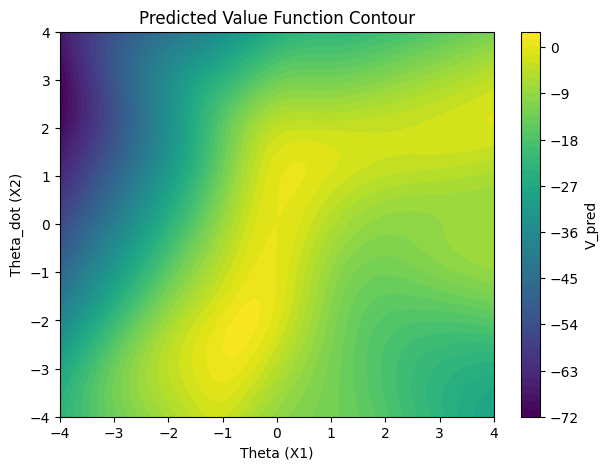

In [98]:
V_exact = None
new_hparams = hparams.copy()
new_hparams['input_range'] = [-4, 4]

nx = 400
x1 = np.linspace(-4, 4, nx)
x2 = np.linspace(-4, 4, nx)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack([X1.ravel(), X2.ravel()]).T
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

with torch.no_grad():  # NO gradients needed
    x_bc = torch.tensor([[0.0, 0.0]], dtype=torch.float32, device=device)
    v_bc = torch.tensor([[0.0]], dtype=torch.float32, device=device)
    g = model(X_tensor).cpu().numpy().reshape(nx, nx)
    # convert tensor boundary predictions to numpy scalars for broadcasting with g
    g_0 = model(x_bc).cpu().numpy().squeeze()
    v_bc_val = v_bc.cpu().numpy().squeeze()
    V_pred = g + v_bc_val - g_0


print(f'{X2.max()}=')
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.contourf(X1, X2, V_pred, levels=50, cmap='viridis')
plt.xlabel('Theta (X1)')
plt.ylabel('Theta_dot (X2)')
plt.title('Predicted Value Function Contour')
plt.colorbar(label='V_pred')
plt.show()


/var/folders/_w/s9pmmwy562s33brj01xynnt80000gn/T/ipykernel_23988/3987568621.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_x2 = (self.g / self.l) * torch.sin(torch.tensor(self.theta)).item()


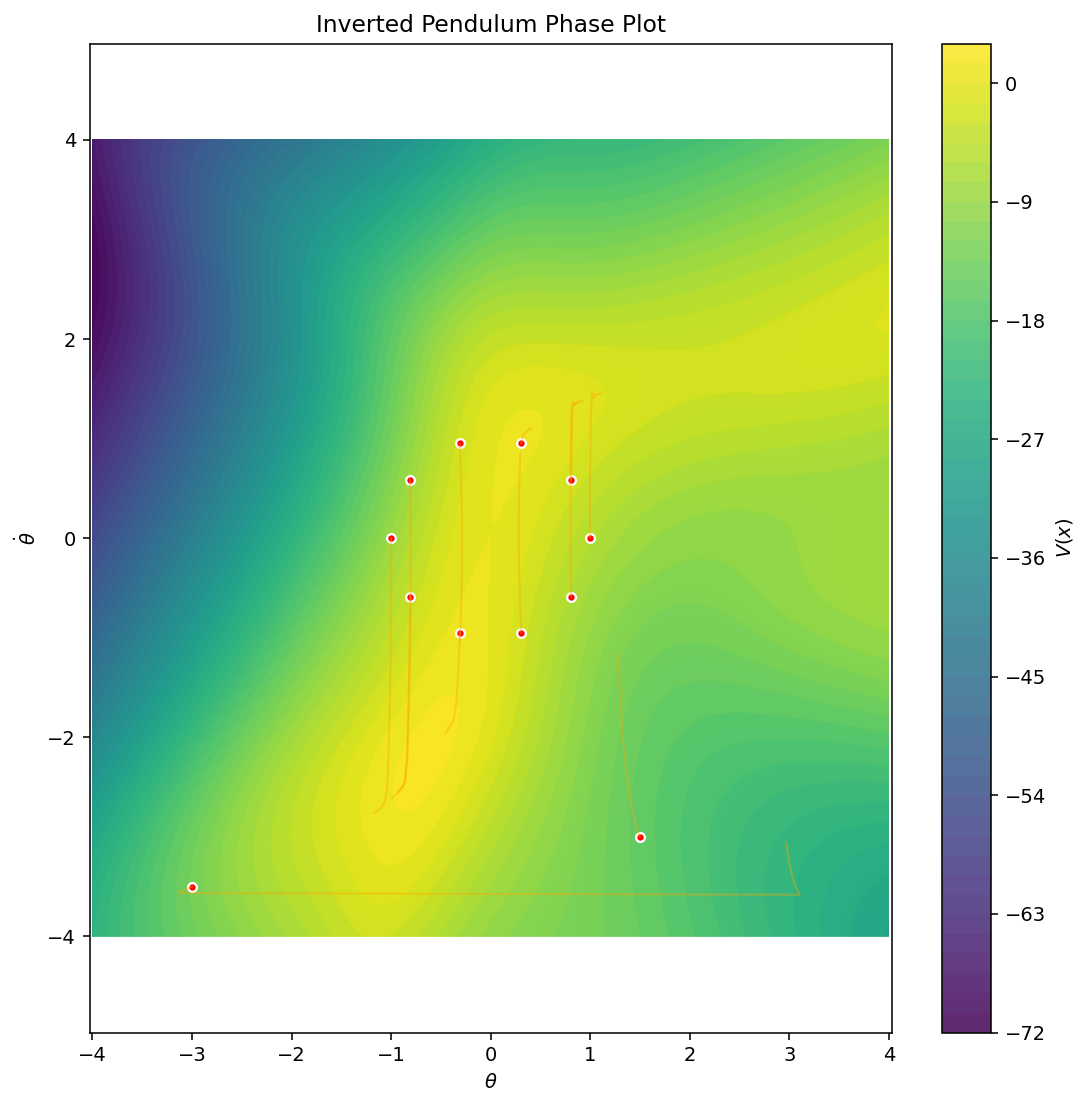

In [99]:
import matplotlib.pyplot as plt

# Define multiple starting points (theta, theta_dot)
num_points = 10
radius = 1.0
starting_points = [
    (radius * np.cos(2 * np.pi * i / num_points), radius * np.sin(2 * np.pi * i / num_points))
    for i in range(num_points)
 ]

# Add more starting points
starting_points.extend([(1.5, -3), (-3, -3.5)])


xmin, xmax = X1.min(), X1.max()
ymin, ymax = X2.min(), X2.max()

plt.figure(figsize=(8, 8), dpi=140)

# Pretty contour background
cont = plt.contourf(
    X1, X2, V_pred,
    levels=60,
    cmap='viridis',
    alpha=0.85,
    extent=[xmin, xmax, ymin, ymax]
 )

plt.imshow(
    V_pred,
    extent=[xmin, xmax, ymin, ymax],
    origin='lower',
    cmap='viridis',
    alpha=0.85,
    aspect='auto'
 )

plt.colorbar(cont, label=r"$V(x)$")

# Initial condition markers
circle_points = np.array(starting_points)
plt.scatter(
    circle_points[:, 0],
    circle_points[:, 1],
    s=20,
    edgecolor='white',
    linewidth=1.2,
    color='red',
    label='Initial Points'
 )

dt = 0.01
steps = 10

# Pretty color cycle
colors = plt.cm.tab10(np.linspace(0, 1, len(starting_points)))

for (theta0, theta_dot0), color in zip(starting_points, colors):
    pendulum = PendulumState(model, hparams)
    pendulum.theta = theta0
    pendulum.theta_dot = theta_dot0

    pos, vel = [], []

    for _ in range(steps):
        pos.append(pendulum.theta)
        vel.append(pendulum.theta_dot)
        pendulum.step(dt, pendulum.control_input)

        if abs(pendulum.theta) + abs(pendulum.theta_dot) < 1e-3:
            break

    pos_np = [float(p) for p in pos]
    vel_np = [float(v) for v in vel]

    plt.plot(
        pos_np, vel_np,
        linewidth=1.0,
        color='orange',
        alpha=0.4,
    )

plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
plt.title("Inverted Pendulum Phase Plot")

plt.xlim(-4, 4)
plt.ylim(-8, 8)

plt.axis('equal')

# Put legend outside
# plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()

/var/folders/_w/s9pmmwy562s33brj01xynnt80000gn/T/ipykernel_23988/2012625138.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))


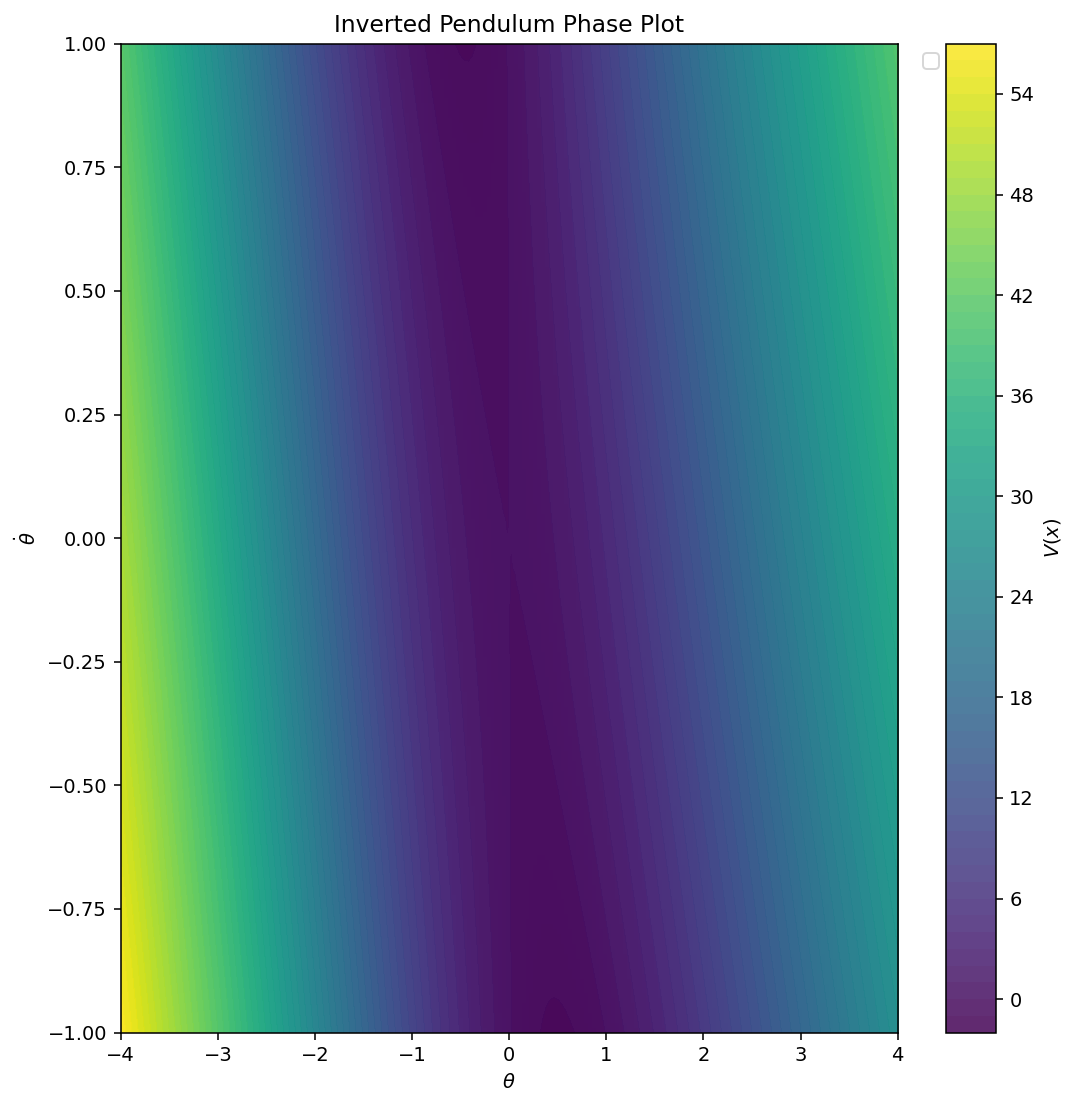

In [45]:
plt.figure(figsize=(8, 8), dpi=140)

# Pretty contour background
cont = plt.contourf(
    X1, X2, V_pred,
    levels=60,
    cmap='viridis',
    alpha=0.85,
    extent=[xmin, xmax, ymin, ymax]
)


plt.imshow(
    V_pred,
    extent=[xmin, xmax, ymin, ymax],
    origin='lower',
    cmap='viridis',
    alpha=0.85,
    aspect='auto'
)

plt.colorbar(cont, label=r"$V(x)$")


plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
plt.title("Inverted Pendulum Phase Plot")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


# Put legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()